### Configure Model

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Activation
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(256,256,3), activation="relu"))
model.add(Conv2D(64, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4, 4)))         #(2,2) ?
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1,  activation='relu'))

model.compile(optimizer="adam",loss="mean_squared_error")
print('Model compiled successfully!')
model.save(filepath="/storage/Manual Model.h5",
               overwrite=True,include_optimizer=True,save_format='h5')
print("Model saved successfully!")

Model compiled successfully!
Model saved successfully!


### Configure Data Generator

In [1]:
import pandas as pd
df = pd.read_csv("/storage/data.csv")
df['filename']="clips-"+df["id"].astype(str)+".png"

df_validate = pd.read_csv("/storage/validate.csv", na_values=['NA', '?'])
df_validate['filename']="clips-"+df_validate["id"].astype(str)+".png"


df_train = df[:40000] #45000 images in total
df_test = df[40000:45000]

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

IMAGES_DIR = "/storage/clips"

training_datagen = ImageDataGenerator(rescale = 1./255., horizontal_flip=True, 
                                      vertical_flip=True, fill_mode='nearest')
train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(256, 256),
        batch_size=64,
        class_mode='other')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(256, 256),
        class_mode='other')

Found 40000 validated image filenames.
Found 5000 validated image filenames.


In [6]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
if("model" not in globals().keys()):
    model=load_model("/storage/Manual Model.h5",compile=False)
    model.compile(optimizer="adam",loss="mean_squared_error")
    print("Successfully loaded h5 model!")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
print("Successfully created callback: Monitor")
checkpoint = ModelCheckpoint("/storage/Manual Model.h5", 
                             monitor='val_loss', verbose=1)
print("Successfully created callback: Checkpoint")
history = model.fit_generator(train_generator, validation_data=test_generator, steps_per_epoch=625,
                    callbacks=[checkpoint,monitor], epochs=200, verbose = 1,
                    initial_epoch=111) 


Successfully created callback: Monitor
Successfully created callback: Checkpoint
Epoch 112/200
624/625 [============================>.] - ETA: 0s - loss: 0.3808
Epoch 00112: saving model to /storage/Manual Model.h5
625/625 [==============================] - 661s 1s/step - loss: 0.3807 - val_loss: 0.5533
Epoch 113/200
624/625 [============================>.] - ETA: 0s - loss: 0.3651
Epoch 00113: saving model to /storage/Manual Model.h5
625/625 [==============================] - 659s 1s/step - loss: 0.3652 - val_loss: 0.8318
Epoch 114/200
624/625 [============================>.] - ETA: 0s - loss: 0.3576
Epoch 00114: saving model to /storage/Manual Model.h5
625/625 [==============================] - 662s 1s/step - loss: 0.3578 - val_loss: 0.5594
Epoch 115/200
624/625 [============================>.] - ETA: 0s - loss: 0.3829
Epoch 00115: saving model to /storage/Manual Model.h5
625/625 [==============================] - 661s 1s/step - loss: 0.3828 - val_loss: 0.6808
Epoch 116/200
624/625 [

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/storage/2020-04-06(0.61).h5",compile=False)
model.compile(optimizer="adam",loss="mean_squared_error")
print("Successfully loaded h5 model!")

In [7]:
import pandas as pd

df_validate = pd.read_csv("/storage/validate.csv", na_values=['NA', '?'])
df_validate['filename']="clips-"+df_validate["id"].astype(str)+".png"

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

IMAGES_DIR = "/storage/clips"

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=df_validate,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="id",
        target_size=(256, 256),
        class_mode='other')

Found 5000 validated image filenames.


In [8]:
from PIL import Image
import numpy as np
from tqdm import tqdm

df = pd.DataFrame()

for i in tqdm(range(5000)):
    arr=np.expand_dims(np.array(Image.open(f"/storage/clips/clips-{25001+i}.png"))/255, 0)
    df.loc[i+25001,"clips"]=model.predict(arr)
df

100%|██████████| 5000/5000 [04:10<00:00, 19.92it/s]


,clips
25001,2.054140
25002,47.178310
25003,63.330708
25004,3.544874
25005,44.842930
...,...
29996,31.811995
29997,55.457638
29998,61.454952
29999,4.945584


In [11]:
df.to_csv("/notebooks/submit.csv")

In [ ]:
! pip install tqdm

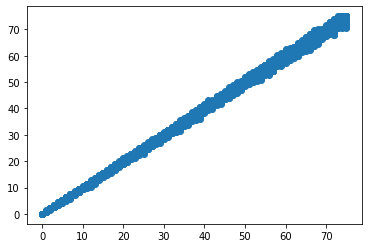

0.5787314589089702

In [10]:
import pandas as pd
df=pd.read_csv("/notebooks/test_prediction.csv")
df.columns=["id","clip_count"]
df["clip_count"]=df["clip_count"].apply(lambda x: 75 if x>75 else x)
df["decimal"]=df["clip_count"]-df["clip_count"].astype("int")
df["integer"]=df["clip_count"].astype("int")
df["True count"]=pd.read_csv("/storage/data.csv")["clip_count"][-5000:].values
df["error"]=df["True count"]-df["clip_count"]
#display(df)
import matplotlib.pyplot as plt
plt.scatter(df["True count"],df["clip_count"])
plt.show()

from sklearn.metrics import mean_squared_error
display(mean_squared_error(df["clip_count"],df["True count"]))